In [1]:
from datasets_dgl.data_dgl import *
from  easydict  import EasyDict
from datasets_dgl.utils import to_scipy

torch.cuda.set_device(0)  # 指第几块GPU

# pubmed 攻击用的是meta_self所以攻击test多
dataset_name = 'Attack-Polblogs'
no_attack = 'Meta_Self-0.0'
attack    = 'Meta_Self-0.25'

################# no attack
DATASET0 = EasyDict()
DATASET0.ATTACK = {
    "data":dataset_name,
    "attack":no_attack.split('-')[0],
    "ptb_rate":no_attack.split('-')[1],
    # if split file
    # "train_size":0.9,
    # "val_size":0.05,
    # "test_size":0.05,
    # "group":9, # train_size * 10
    # "use_g1_split":False
}
dataset  = load_attack_data(DATASET0['ATTACK'])
graph = dataset.graph
graph = dgl.remove_self_loop(graph) # 如果不可视化自环的话就用

#################  attack
DATASET1 = EasyDict()
DATASET1.ATTACK = {
    "data":dataset_name,
    "attack":attack.split('-')[0],
    "ptb_rate":attack.split('-')[1],
    # if split file
    # "train_size":0.9,
    # "val_size":0.05,
    # "test_size":0.05,
    # "group":9, # train_size * 10
    # "use_g1_split":False
}
dataset  = load_attack_data(DATASET1['ATTACK'])
graph_attack = dataset.graph
graph_attack = dgl.remove_self_loop(graph_attack)

print(graph)
print(graph_attack)

/home/songsh/anaconda3/envs/ALOHA/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[I] Loading dataset Attack-Polblogs...
train_mask, test_mask, val_mask sizes : tensor(121) tensor(123) tensor(978)
[I] Finished loading.
[I] Data load time: 0.9131s
[I] Loading dataset Attack-Polblogs...
train_mask, test_mask, val_mask sizes : tensor(121) tensor(123) tensor(978)
[I] Finished loading.
[I] Data load time: 0.0103s
Graph(num_nodes=1222, num_edges=33428,
      ndata_schemes={'feat': Scheme(shape=(1490,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})
Graph(num_nodes=1222, num_edges=41204,
      ndata_schemes={'feat': Scheme(shape=(1490,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [2]:
adj           = graph.adj().to_dense()
perturbed_adj = graph_attack.adj().to_dense()

idx_train = graph_attack.ndata['train_mask'].nonzero().squeeze().numpy()
idx_val = graph_attack.ndata['val_mask'].nonzero().squeeze().numpy()
idx_test = graph_attack.ndata['test_mask'].nonzero().squeeze().numpy()

idx_unlabeled = np.union1d(idx_val, idx_test)
idx_all = np.union1d(idx_unlabeled, idx_train)
for i in range(len(adj)):
    if i not in idx_all:
        idx_unlabeled = np.union1d(idx_unlabeled, i)

In [3]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}

In [4]:
def adjust_idx(adj, idx_train, idx_unlabeled):
    new_adj = adj.clone()
    new_adj[:len(idx_train)][:, :len(idx_train)] = adj[idx_train][:, idx_train]
    new_adj[len(idx_train):][:, :len(idx_train)] = adj[idx_unlabeled][:, idx_train]
    new_adj[:len(idx_train)][:, len(idx_train):] = adj[idx_train][:, idx_unlabeled]
    new_adj[len(idx_train):][:, len(idx_train):] = adj[idx_unlabeled][:, idx_unlabeled]
    return new_adj

In [5]:
changed = torch.abs(perturbed_adj - adj)

adj             = adjust_idx(adj, idx_train, idx_unlabeled)
perturbed_adj   = adjust_idx(perturbed_adj, idx_train, idx_unlabeled)
changed         = adjust_idx(changed, idx_train, idx_unlabeled)

perturbed_adj = to_scipy(perturbed_adj)
adj           = to_scipy(adj)
changed       = to_scipy(changed)

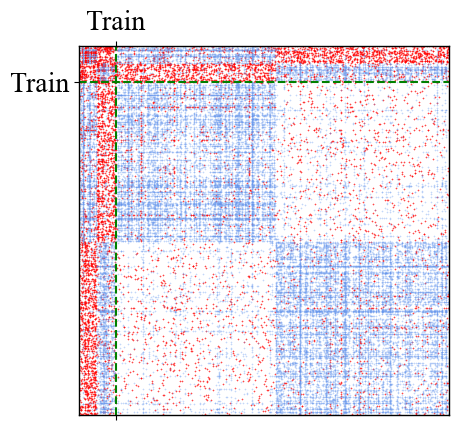

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default') # 风格设置默认即可，要不是全黑


adj_view = changed
ax = plt.gca()
ax.spines['bottom'].set_linewidth('1.0')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth('1.0')
ax.spines['left'].set_color('black')
ax.spines['top'].set_linewidth('1.0')
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth('1.0')
ax.spines['right'].set_color('black')
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.spy(adj_view, markersize=0.2, color='r')
plt.spy(adj, markersize=0.2, color='cornflowerblue', alpha=0.5)
plt.yticks([len(idx_train)], ['Train'], font=font1)
plt.xticks([len(idx_train)], ['Train'], font=font1)
plt.axvline(len(idx_train), color="green", ls='--')
plt.axhline(len(idx_train), color="green", ls='--')
# plt.savefig('%s_distribution.pdf'%(args.dataset),dpi=800, format='pdf', bbox_inches = 'tight')
# plt.savefig('./save_exp_record/Meta_Self_cora_0.25_0.9_0.05_0.05.pdf',dpi=800, format='pdf', bbox_inches = 'tight')
plt.show()